[View in Colaboratory](https://colab.research.google.com/github/aayushkumarjvs/Deep-Crypto-Predict/blob/master/Deep_crypto_predict.ipynb)

In [0]:
#!/usr/bin/env python3 
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc
import os
import sys


In [0]:
# Installing all relevant keras modules
!pip install -q keras   # This only required for Google's Colab 
import keras
from keras.models import Sequential
from keras.layers import Activation,Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [0]:
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer = 'adam'
dropout = 0.50                  # the dropout is adjusted to 0.50
batch_size = 128                # allowing the batch size to be 128
epochs = 50
window_len = 7                 # int to be used as the look back window for single input sample
training_size = 0.7            # training on 70% of the obtained data 
merge_date = '2016-01-01'      # earliest date which we have for both ETH and BTC data

In [0]:
def get_market_data(market, tag=True):                                               # To extract data from coinmarketcap.com/currencies
 
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))              # Using df.fillna() prior to using  pd.to_numeric to avoid NaN values
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


In [0]:
def merge_data(a, b, from_date=merge_date):
 
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


In [0]:
def add_volatility(data, coins=['btc', 'eth']):
 
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,  # kwargs allow you to pass a variable number of arguments to a f#unction
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data
                                                                                          # For more info, this (https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/)


In [0]:
def create_model_data(data):
                                                                                                      
  #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]   
  #btc refres to bitcoin and eth refers to etherium
  data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data


In [0]:
def split_data(data, training_size=0.7):
  
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]                                     # returning the data from initial state to final train split


In [0]:
def create_inputs(data, coins=['btc', 'eth'], window_len=window_len):
  
  # Taking the coin values as inputs and dynamically updating it for evry rise in the bitcoin price as seen in coinmarketcap.com
  
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)                                                          # appending the previous input
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs

In [0]:
def create_outputs(data, coin, window_len=window_len):
 
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1



In [0]:
def to_array(data):                           # Toc convert the existing data into an array.
  
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)

In [0]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  model = Sequential()
  # 1st LSTM cell
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  # 2nd LSTM cell
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  # 3rd LSTM cell
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  # Dense layer 
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  # Compiling the model
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])               
  # I've used optimizer as adam, you can even look out for other optimizers and loss functions from here (https://keras.io/)
  model.summary()
  return model

In [0]:
def show_plot(data, tag):                                                                         # To make a 
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')                       # Adjusting a min-max range for the data to be mapped on the graph
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  
def date_labels():
  last_date = market_data.iloc[0, 0]                                                # iloc is for parsing the data instead you can even use head-tail split
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

In [0]:
btc_data = get_market_data("bitcoin", tag='btc')
eth_data = get_market_data("ethereum", tag='eth')                    

In [82]:
btc_data.head()                                       # Trying to fit in the btc_data, you can even plot for one eth or any other considered coin

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap
0,2018-04-11,6843.47,6968.32,6817.59,6968.32,4.641890e+09,116126000000
1,2018-04-10,6795.44,6872.41,6704.15,6834.76,4.272750e+09,115306000000
2,2018-04-09,7044.32,7178.11,6661.99,6770.73,4.894060e+09,119516000000
3,2018-04-08,6919.98,7111.56,6919.98,7023.52,3.652500e+09,117392000000
4,2018-04-07,6630.51,7050.54,6630.51,6911.09,3.976610e+09,112467000000


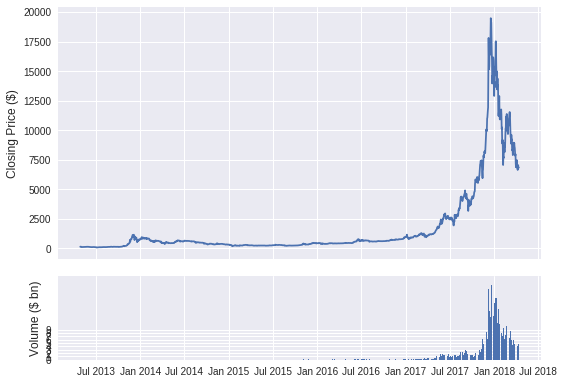

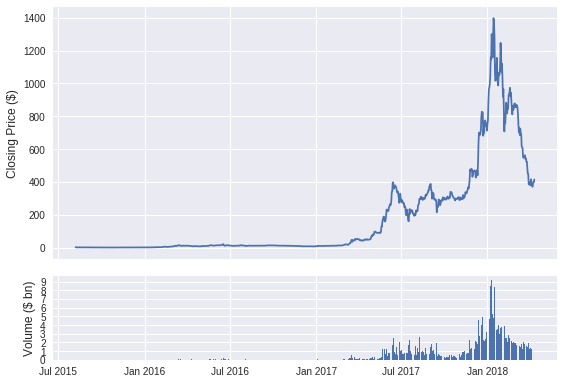

In [83]:
show_plot(btc_data, tag='btc')
show_plot(eth_data, tag='eth')

In [0]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [85]:
model_data.head()                                        # To plot the eth data and compare with the btc data

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume
831,2016-01-01,434.33,36278900.0,0.948024,206062
830,2016-01-02,433.44,30096600.0,0.937124,255504
829,2016-01-03,430.01,39633800.0,0.971905,407632
828,2016-01-04,433.09,38477500.0,0.954480,346245
827,2016-01-05,431.96,34522600.0,0.950176,219833


In [86]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='btc')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='btc')

Y_train_eth = create_outputs(train_set, coin='eth')
Y_test_eth = create_outputs(test_set, coin='eth')

X_train, X_test = to_array(X_train), to_array(X_test)

date_list = date_labels()
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(575, 7, 4) (243, 7, 4) (575,) (243,)
(575, 7, 4) (243, 7, 4) (575,) (243,)


In [87]:
len(Y_test_btc)

243

In [88]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(123)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 7, 512)            1058816   
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 7, 512)            2099200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
__________

575/575 [==============================] - 4s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0513 - val_loss: 0.0124 - val_mean_absolute_error: 0.0871
Epoch 9/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0447 - val_loss: 0.0123 - val_mean_absolute_error: 0.0851
Epoch 10/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0449 - val_loss: 0.0107 - val_mean_absolute_error: 0.0807
Epoch 11/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0418 - val_loss: 0.0098 - val_mean_absolute_error: 0.0764
Epoch 12/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0033 - mean_absolute_error: 0.0395 - val_loss: 0.0094 - val_mean_absolute_error: 0.0743
Epoch 13/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0368 - val_loss: 0.0088 - val_mean_absolute_error: 0.0717
Epoch 14/50
575/575 [==

575/575 [==============================] - 4s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0340 - val_loss: 0.0061 - val_mean_absolute_error: 0.0569
Epoch 23/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0320 - val_loss: 0.0062 - val_mean_absolute_error: 0.0574
Epoch 24/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0330 - val_loss: 0.0059 - val_mean_absolute_error: 0.0560
Epoch 25/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0322 - val_loss: 0.0063 - val_mean_absolute_error: 0.0585
Epoch 26/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0339 - val_loss: 0.0059 - val_mean_absolute_error: 0.0559
Epoch 27/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0022 - mean_absolute_error: 0.0326 - val_loss: 0.0056 - val_mean_absolute_error: 0.0547
Epoch 28/50
575/575 [=

575/575 [==============================] - 4s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0049 - val_mean_absolute_error: 0.0504
Epoch 37/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0293 - val_loss: 0.0047 - val_mean_absolute_error: 0.0494
Epoch 38/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0288 - val_loss: 0.0048 - val_mean_absolute_error: 0.0499
Epoch 39/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0285 - val_loss: 0.0046 - val_mean_absolute_error: 0.0491
Epoch 40/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0294 - val_loss: 0.0047 - val_mean_absolute_error: 0.0492
Epoch 41/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0048 - val_mean_absolute_error: 0.0498
Epoch 42/50
575/575 [=

575/575 [==============================] - 4s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 0.0043 - val_mean_absolute_error: 0.0473


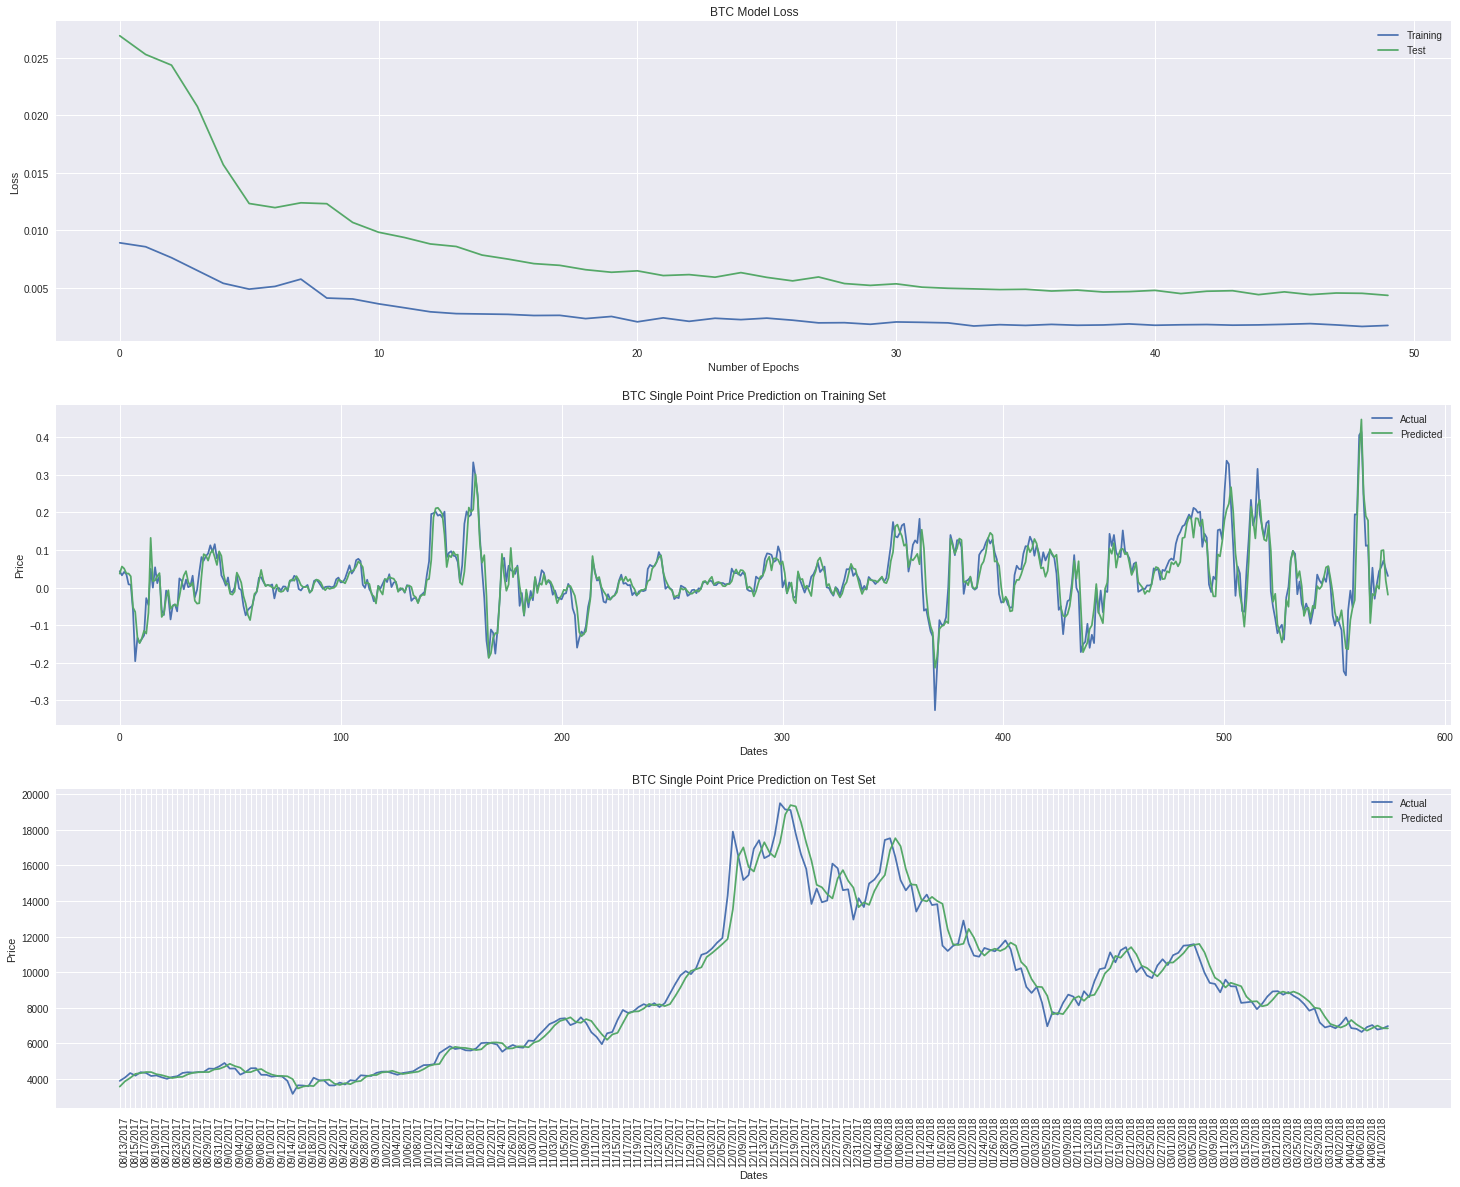

In [89]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot(btc_history.epoch, btc_history.history['loss'], )
plt.plot(btc_history.epoch, btc_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('BTC Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(312)
plt.plot(Y_train_btc)
plt.plot(btc_model.predict(X_train))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction on Training Set')
plt.legend(['Actual','Predicted'])

ax1 = plt.subplot(313)
plt.plot(test_set['btc_Close'][window_len:].values.tolist())
plt.plot(((np.transpose(btc_model.predict(X_test))+1) * test_set['btc_Close'].values[:-window_len])[0])
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction on Test Set')
plt.legend(['Actual','Predicted'])

ax1.set_xticks([x for x in range(len(date_list))])
for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
  label.set_visible(False)

plt.show()

In [90]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(123)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 512)            1058816   
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 7, 512)            2099200   
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
__________

575/575 [==============================] - 4s 7ms/step - loss: 0.0200 - mean_absolute_error: 0.0939 - val_loss: 0.0082 - val_mean_absolute_error: 0.0666
Epoch 9/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0192 - mean_absolute_error: 0.0919 - val_loss: 0.0080 - val_mean_absolute_error: 0.0642
Epoch 10/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0166 - mean_absolute_error: 0.0856 - val_loss: 0.0074 - val_mean_absolute_error: 0.0626
Epoch 11/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0178 - mean_absolute_error: 0.0878 - val_loss: 0.0072 - val_mean_absolute_error: 0.0612
Epoch 12/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0161 - mean_absolute_error: 0.0819 - val_loss: 0.0071 - val_mean_absolute_error: 0.0598
Epoch 13/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0155 - mean_absolute_error: 0.0833 - val_loss: 0.0065 - val_mean_absolute_error: 0.0608
Epoch 14/50
575/575 [==

575/575 [==============================] - 4s 7ms/step - loss: 0.0122 - mean_absolute_error: 0.0739 - val_loss: 0.0050 - val_mean_absolute_error: 0.0494
Epoch 23/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0137 - mean_absolute_error: 0.0752 - val_loss: 0.0049 - val_mean_absolute_error: 0.0486
Epoch 24/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0142 - mean_absolute_error: 0.0791 - val_loss: 0.0054 - val_mean_absolute_error: 0.0515
Epoch 25/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0136 - mean_absolute_error: 0.0752 - val_loss: 0.0053 - val_mean_absolute_error: 0.0513
Epoch 26/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0126 - mean_absolute_error: 0.0735 - val_loss: 0.0058 - val_mean_absolute_error: 0.0540
Epoch 27/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0115 - mean_absolute_error: 0.0705 - val_loss: 0.0052 - val_mean_absolute_error: 0.0501
Epoch 28/50
575/575 [=

575/575 [==============================] - 4s 7ms/step - loss: 0.0103 - mean_absolute_error: 0.0656 - val_loss: 0.0044 - val_mean_absolute_error: 0.0451
Epoch 37/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0100 - mean_absolute_error: 0.0658 - val_loss: 0.0045 - val_mean_absolute_error: 0.0479
Epoch 38/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0104 - mean_absolute_error: 0.0679 - val_loss: 0.0044 - val_mean_absolute_error: 0.0455
Epoch 39/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.0626 - val_loss: 0.0043 - val_mean_absolute_error: 0.0453
Epoch 40/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0098 - mean_absolute_error: 0.0656 - val_loss: 0.0044 - val_mean_absolute_error: 0.0459
Epoch 41/50
575/575 [==============================] - 4s 7ms/step - loss: 0.0102 - mean_absolute_error: 0.0660 - val_loss: 0.0043 - val_mean_absolute_error: 0.0465
Epoch 42/50
575/575 [=

575/575 [==============================] - 4s 7ms/step - loss: 0.0095 - mean_absolute_error: 0.0637 - val_loss: 0.0042 - val_mean_absolute_error: 0.0449


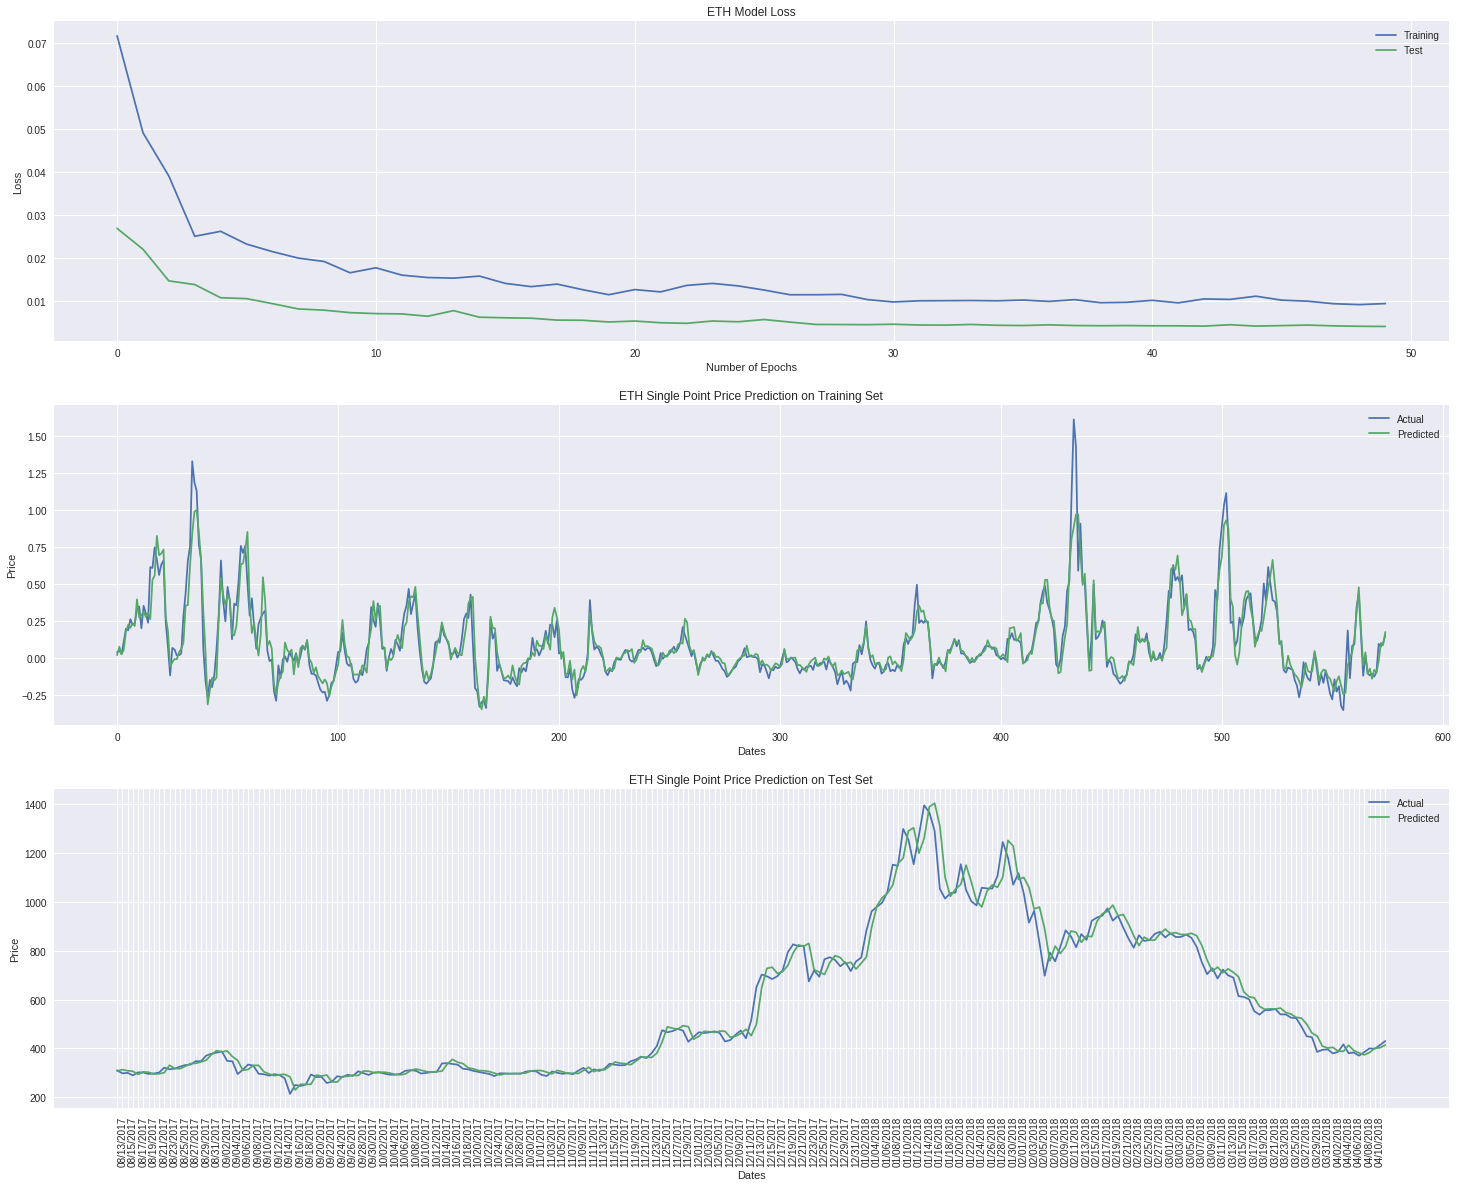

In [91]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot(eth_history.epoch, eth_history.history['loss'], )
plt.plot(eth_history.epoch, eth_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('ETH Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(312)
plt.plot(Y_train_eth)
plt.plot(eth_model.predict(X_train))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction on Training Set')
plt.legend(['Actual','Predicted'])

ax2 = plt.subplot(313)
plt.plot(test_set['eth_Close'][window_len:].values.tolist())
plt.plot(((np.transpose(eth_model.predict(X_test))+1) * test_set['eth_Close'].values[:-window_len])[0])
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction on Test Set')
plt.legend(['Actual','Predicted'])

ax2.set_xticks([x for x in range(len(date_list))])
for label in ax2.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
  label.set_visible(False)

plt.show()